In [2]:
import sys

In [3]:
!{sys.executable} -m pip install -r ../requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def myconvolve2d(img, kernel):
    kernel_height = kernel.shape[0]
    kernel_height_halved = int((kernel_height-1)/2)
    kernel_width = kernel.shape[1]
    kernel_width_halved = int((kernel_width-1)/2)
    img = np.pad(img, ((kernel_height_halved, kernel_height_halved), 
                    (kernel_width_halved, kernel_width_halved)), 
                mode='constant', constant_values=0)
    img_height = img.shape[0]
    img_width = img.shape[1]
    convolution = []
    # start at row kernel_height_halved, end at row img_height-kernel_height_halved
    for i in range(kernel_height_halved, img_height-kernel_height_halved):
        lst = []
        # start at col kernel_width_halved, end at col img_width-kernel_height_halved
        for j in range(kernel_width_halved, img_width-kernel_width_halved):
            lst.append((img[i-kernel_height_halved:i+kernel_height_halved+1,
                            j-kernel_width_halved:j+kernel_width_halved+1] * kernel).sum().item())
        convolution.append(lst)
    return np.array(convolution)


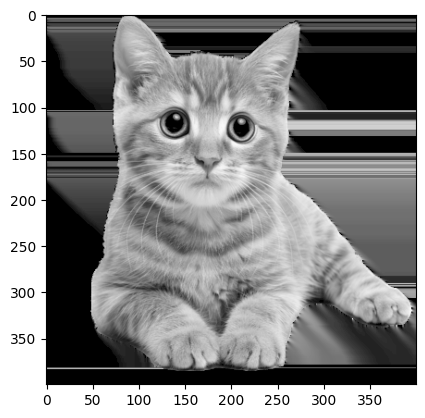

In [5]:
img = cv2.imread("../cat.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [6]:
# Discrete Fourier Transform (DFT) in 2 dimensions with time complexity O(N^2 * M^2)
def dft2d(img):
    M, N = img.shape
    freqs = np.zeros((M, N), dtype=np.complex128)
    for u in range(M):
        for v in range(N):
            sum = 0
            for x in range(M):
                for y in range(N):
                    angle = -2j * np.pi * ((u * x / M) + (v * y / N))
                    sum += img[x, y] * np.exp(angle)
            freqs[u, v] = sum
    return freqs

In [6]:
F = dft2d(img)
magnitude = np.abs(F)
plt.imshow(np.log(magnitude + 1), cmap="gray")
plt.title("Magnitude Spectrum (DFT)")

KeyboardInterrupt: 

In [7]:
# Cooley-Tukey recursive Fast Fourier Transform (FFT) in 1 Dimension with time complexity O(N * log N)
def fft1d(x):
    N = len(x)
    if N <= 1:
        return x
    
    # start at index = 0, end at index = len(x)-1, step size = 2
    even = fft1d(x[::2])
    # start at index = 1, end at index = len(x)-1, step size = 2
    odd = fft1d(x[1::2])

    X = [0] * N
    for k in range(N // 2):
        twiddle_factor = np.exp(-2j * np.pi * k / N)
        X[k] = even[k] + twiddle_factor * odd[k]
        X[k + N // 2] = even[k] - twiddle_factor * odd[k]

    return X

In [8]:
# 2D extension of FFT 1D to apply to rows, transpose, then apply to its cols, transpose in O(MN * log MN)
def fft2d(img):
    # apply 1D FFT on rows
    fft_rows = [fft1d(row) for row in img]
    fft_rows = np.array(fft_rows).T  # transpose

    # apply 1D FFT on cols
    fft_cols = [fft1d(col) for col in fft_rows]
    return np.array(fft_cols).T  # transpose

In [9]:
img_fft = fft2d(img)

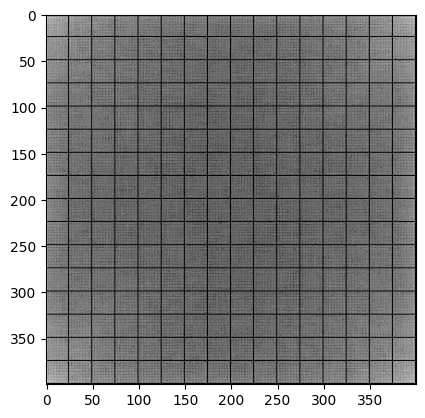

In [10]:
cat_mag = np.log(np.abs(img_fft) + 1)
plt.imshow(cat_mag, cmap='gray')

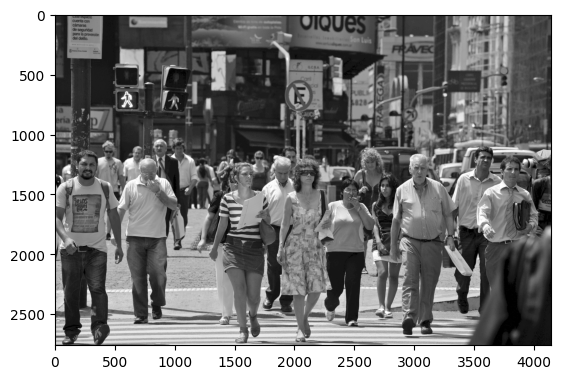

In [11]:
ped_img = cv2.imread("../pedestrians.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(ped_img, cmap='gray')

In [12]:
fft_ped_img = fft2d(ped_img)

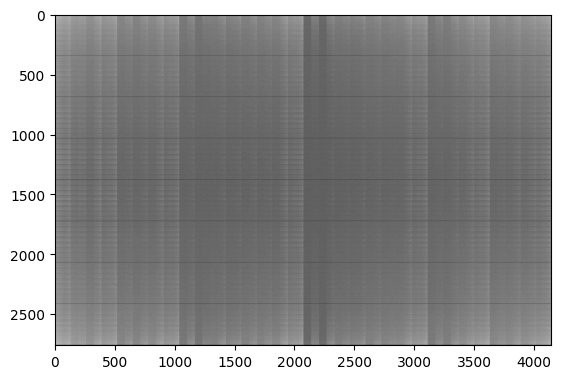

In [14]:
ped_mag = np.log(np.abs(fft_ped_img) + 1)
plt.imshow(ped_mag, cmap='gray')

Text(0.5, 1.0, 'Log Magnitude Spectrum')

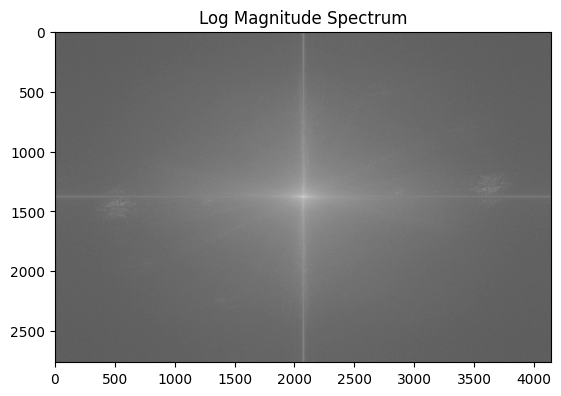

In [ ]:
F = np.fft.fft2(ped_img) # 2D FFT
F_shifted = np.fft.fftshift(F) # Center low frequencies
magnitude = np.log(np.abs(F_shifted) + 1)
plt.imshow(magnitude, cmap='gray')

In [14]:
from scipy.signal import convolve2d

# Low-pass filter, building a circular mask
def low_pass_mask(shape, cutoff):
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    cy, cx = H // 2, W // 2
    dist = np.sqrt((Y - cy)**2 + (X - cx)**2)
    return dist < cutoff

def apply_low_pass_mask(img, cutoff=30):
    low_mask = low_pass_mask(img.shape, cutoff)
    F = np.fft.fft2(img) # 2D FFT
    F_shifted = np.fft.fftshift(F) # Center low frequencies
    F_filtered = F_shifted * low_mask
    return np.fft.ifft2(np.fft.ifftshift(F_filtered)).real

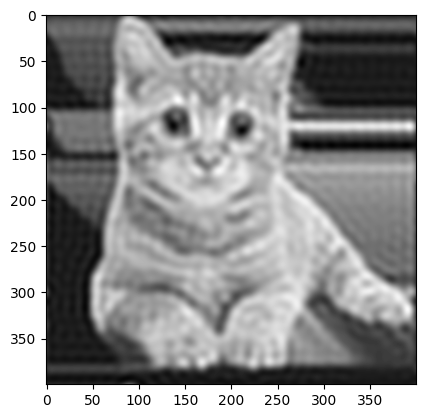

In [15]:
plt.imshow(apply_low_pass_mask(img), cmap='gray')

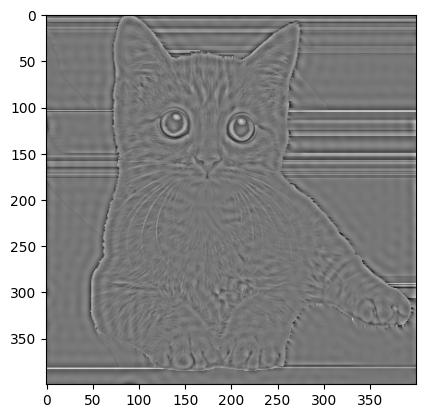

In [17]:
# High-pass filter keeps only high frequencies, enhancing edges, small texture, and noise
def apply_high_pass_mask(img, cutoff):
    high_mask = ~low_pass_mask(img.shape, cutoff)
    F_high = F_shifted * high_mask
    return np.fft.ifft2(np.fft.ifftshift(F_high)).real

plt.imshow(apply_high_pass_mask(img, cutoff=30), cmap='gray')

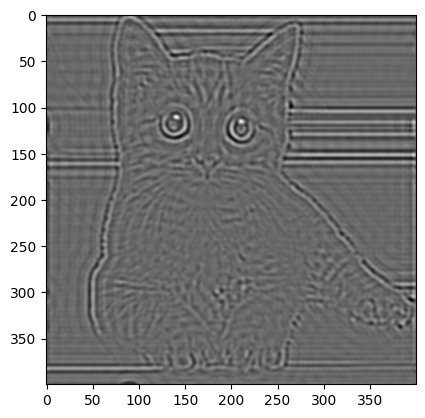

In [18]:
# Band pass filter keeps only mid-range frequencies
def band_pass_mask(shape, low, high):
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    cy, cx = H // 2, W // 2
    dist = np.sqrt((Y - cy)**2 + (X - cx)**2)
    return (dist > low) & (dist < high)

def apply_band_pass_mask(img, low=30, high=70):
    band_mask = band_pass_mask(img.shape, low, high)
    F_high = F_shifted * band_mask
    return np.fft.ifft2(np.fft.ifftshift(F_high)).real

plt.imshow(apply_band_pass_mask(img, 30, 70), cmap='gray')